In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import  nangs 
import  torch
#import cv2
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [3]:
from nangs import PDE
import math

K=50

class PeronaMalik(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        #dudas
        dp2dpxdpy=self.computeGrads(dpdx, inputs)[:, 1]
        dp2dpydpx=self.computeGrads(dpdy, inputs)[:, 0]
        
        
        # compute loss
        #dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdx*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dx2)+(dpdy*dp2dpydpx))
                      -dpdy*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dpxdpy)+(dpdy*dp2dy2))
               +torch.exp(  -(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2) * ( dp2dx2+dp2dy2 )-dpdt}
    
pde = PeronaMalik(inputs=('x', 'y', 't'), outputs='p')

In [4]:
n_samples = 500
print("a")

a


In [5]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [0., 1.], 
    'y': [0., 1.],
    't': [0., 1.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)
print("a")

a


In [6]:
def cero_f(n_samples):
    return torch.zeros(n_samples)

In [7]:
def f_circle(x,y):
    z = (x - 0.5)**2 + (y - 0.5)**2
    for i in range(0,len(z)):
        if z[i] <= 0.1:
            z[i] = 0.5
        else: z[i] = 1

    return z

In [8]:
def cart_prod(*args):
    grids =np.meshgrid(*args,indexing='ij')
    return np.stack(grids,axis=-1).reshape(-1,len(args))

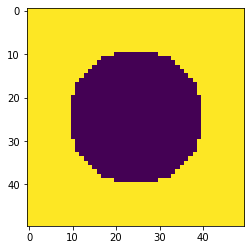

In [9]:
x = np.linspace(0,1,50)

grid=cart_prod(x,x)


xs, ys= grid[:, 0:1], grid[:,1:2]

plt.imshow(f_circle(xs,ys).reshape(50,50))


In [10]:
#from nangs import Dirichlet


#left = Dirichlet(
#    RandomSampler({'x': 0., 'y': [0., 200.],'t': [0., 200.] }, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : cero_f(n_samples)},
#    name="left"
#)

#pde.add_boco(left)
#print("a")

In [11]:
#from nangs import Dirichlet


#right = Dirichlet(
#    RandomSampler({'x': 200., 'y': [0., 200.],'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' :  cero_f(n_samples)},
#    name="right"
#)

#pde.add_boco(right)
#print("a")

In [12]:
#from nangs import Dirichlet


#up = Dirichlet(
#    RandomSampler({'x': [0.,200.], 'y': 0,'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : cero_f(n_samples)},
#    name="up"
#)

#pde.add_boco(up)
#print("a")

In [13]:
#from nangs import Dirichlet


#down = Dirichlet(
#    RandomSampler({'x': [0.,200.], 'y': 0,'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : cero_f(n_samples)},
#    name="down"
#)

#pde.add_boco(down)
#print("a")

In [14]:
from nangs import Dirichlet


foto = Dirichlet(
    RandomSampler({'x': [0., 1.], 'y': [0., 1.],'t':0}, device=device, n_samples=n_samples), 
     lambda inputs: {'p' :f_circle(inputs['x'],inputs['y'])},
    name="foto"
)

pde.add_boco(foto)
print("a")

a


In [15]:
import torch


class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)
    
    #def anzatc(self, u, xs):
    #    """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
    #    # Get tensor of spatial variables and time-tensor.
    #    xs_spatial = xs[:, :self.ndims_spatial]
    #    t = xs[:, self.ndims - 1:self.ndims]
    #    lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
    #    lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
    #                                    for lst in (lower, upper)]
    #    t0 = lower[-1]

        # Apply transformation to bind the boundary condition.
    #    if self.boundary_condition is not None:
    #        u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
    #                  torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
    #                 + self.boundary_condition)

        # Apply transformation to bind the initial condition.
    #    if self.initial_condition is not None:
    #        _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
    #        u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
    #             + self.initial_condition(*_xs_spatial).view(-1, 1))
    #    return u

In [16]:
# solve

#from nangs import MLP

LR = 1e-2
N_STEPS = 5000
NUM_LAYERS = 3
NUM_HIDDEN = 128
print(len(pde.inputs))
print(len(pde.outputs))

for item in pde.inputs:
    print(item)
for item in pde.outputs:
    print(item)
    
    
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

3
1
x
y
t
p


{'pde': 0.00022, 'foto': 0.06142}:   5%|██▎                                         | 269/5000 [01:05<19:10,  4.11it/s]


KeyboardInterrupt: 

In [17]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

NameError: name 'hist' is not defined

In [ ]:
x = np.linspace(0,1,200)
y = np.linspace(0,1,200)

t=0

grid=cart_prod(x,y,t)
xs, ys= grid[:, 0:1], grid[:,1:2]

In [ ]:
print(f_circle(xs,ys).reshape(200,200).shape)
print(f_circle(xs,ys).reshape(200,200).dtype)
plt.imshow(f_circle(xs,ys).reshape(200,200))


In [2]:

X = torch.from_numpy(grid).float().to(device)
image_final =  pde.eval(X)

xs, ys= grid[:, 0:1], grid[:,1:2]
print(image_final.shape)
print(image_final.dtype)

#plt.imshow(f_circle(xs,ys).reshape(200,200))

NameError: name 'torch' is not defined

In [ ]:
imashow=image_final.reshape(200,200)

In [ ]:
def float_to_int(imashow):
    for i in range(len(imashow)):
        for j in range (len(imashow)):
            imashow[i][j]=int(imashow[i][j])

In [ ]:
float_to_int(imashow)
plt.imshow(imashow)

In [68]:
print(imashow)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
